In [1]:
import pandas as pd
import numpy as np
import os

os.chdir("../../data")
path="train.parquet"
cluster_path = "steam_data_clustered.parquet"

In [2]:
df = pd.read_parquet(path)
cluster = pd.read_parquet(cluster_path)

In [3]:
# Merge
df = pd.merge(df, cluster, on="app_id")

# description_courte
df = df.drop(columns=["description_courte_y"])
df = df.rename(columns={"description_courte_x": "description_courte"})

# tags_utilisateurs
df = df.drop(columns=["tags_utilisateurs_y"])
df = df.rename(columns={"tags_utilisateurs_x": "tags_utilisateurs"})
df["description_courte"] = df["description_courte"].astype(str)

df = df.loc[:, ~df.columns.duplicated()]
assert not df.columns.duplicated().any()

del cluster

In [4]:
emb_cols = [c for c in df.columns if c.startswith('emb_')]
df = df.loc[:, ~df.columns.str.startswith('emb')]
df = df.loc[:, ~df.columns.str.startswith('configuration')]
df = df.rename(columns={"donnees_commerciales_prix_initial":"prix"})

df["support_manette"] = df["support_manette"].astype(object)  # permet de mélanger strings et bool
df["support_manette"] = df["support_manette"].replace("full", True)
df["support_manette"] = df["support_manette"].fillna(False).infer_objects()
df["support_manette"] = df["support_manette"].astype(bool)  # conversion finale en bool

df["mois_sin"] = np.sin(2 * np.pi * df["mois"] / 12)
df["mois_cos"] = np.cos(2 * np.pi * df["mois"] / 12)

/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_48860/3169710223.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["support_manette"] = df["support_manette"].fillna(False).infer_objects()


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error,median_absolute_error
import pandas as pd
import numpy as np
# Algorithmes
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge

Defaulting to user installation because normal site-packages is not writeable


In [6]:
def clean_text_col(x):
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(i) for i in x])
    return str(x) if pd.notna(x) else ""

In [7]:
X = df[["support_manette","prix","nombre_succes",]].copy()
numeric_cols = ["prix", "nombre_succes"]
Y = df['review']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


Test Base Line

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lr.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Linear Regression R2: 6.315571883774851e-05
Linear Regression RMSE: 4760.922516003459
           Feature       Coef
2    nombre_succes  81.294898
1             prix   6.626937
0  support_manette   0.000000


In [9]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # RF tolère non-scalé
y_pred_rf = rf.predict(X_test)
print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: -0.21598972371765224
Random Forest RMSE: 5250.126652058592


In [10]:
mlp = MLPRegressor(hidden_layer_sizes=(32,16), max_iter=2000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print("MLP R2:", r2_score(y_test, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))

MLP R2: 0.012518249705015805
MLP RMSE: 4731.178863615768


In [11]:
# Colonnes catégorielles
categorical_cols = ["support_manette"]  # à adapter selon ton df

# On crée le modèle CatBoost
catboost_model = CatBoostRegressor(
    iterations=5000,
    depth=6,
    learning_rate=0.05,
    random_seed=42,
    verbose=500
)

# CatBoost peut gérer les NaN et les catégories directement, donc pas besoin de get_dummies
catboost_model.fit(
    X_train, y_train,
    cat_features=categorical_cols
)

# Prédiction
y_pred_catboost = catboost_model.predict(X_test)

# Scores
print("CatBoost R2:", r2_score(y_test, y_pred_catboost))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_catboost)))

0:	learn: 6380.4171448	total: 60.3ms	remaining: 5m 1s
500:	learn: 4684.7969165	total: 988ms	remaining: 8.88s
1000:	learn: 4232.7978495	total: 1.82s	remaining: 7.27s
1500:	learn: 4087.0073368	total: 2.61s	remaining: 6.09s
2000:	learn: 3984.4444894	total: 3.42s	remaining: 5.13s
2500:	learn: 3936.1798016	total: 4.36s	remaining: 4.36s
3000:	learn: 3909.1822653	total: 5.24s	remaining: 3.49s
3500:	learn: 3879.4615491	total: 6.12s	remaining: 2.62s
4000:	learn: 3863.2885440	total: 6.91s	remaining: 1.73s
4500:	learn: 3852.0474575	total: 7.76s	remaining: 860ms
4999:	learn: 3843.7962207	total: 8.88s	remaining: 0us
CatBoost R2: -0.12002482494228595
CatBoost RMSE: 5038.701748405515


Test avec logtransforme

In [12]:
y_test_log = np.log1p(y_test)
y_train_log = np.log1p(y_train)

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train_log)
y_pred_lr = lr.predict(X_test)
y_pred = np.expm1(y_pred_lr)
print("Linear Regression R2 (log sapce):", r2_score(y_test_log, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lr.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Linear Regression R2 (log sapce): 0.007965313515655215
Linear Regression RMSE: 4770.827922541301
           Feature      Coef
2    nombre_succes  0.188164
1             prix  0.003857
0  support_manette  0.000000


In [14]:
mlp = MLPRegressor(hidden_layer_sizes=(32,16),max_iter=2000, random_state=42,early_stopping=True,solver='adam')
mlp.fit(X_train, y_train_log)
y_pred_mlp = mlp.predict(X_test)
y_pred = np.expm1(y_pred_mlp)
print("MLP R2:", r2_score(y_test_log, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MLP R2: 0.41796828949291076
MLP RMSE: 4765.610284088552


In [15]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)  # RF tolère non-scalé
y_pred_rf = rf.predict(X_test)
y_pred = np.expm1(y_pred_rf)
print("Random Forest R2:", r2_score(y_test_log, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: 0.3921192196825194
Random Forest RMSE: 4770.6717414115665


In [16]:
# Colonnes catégorielles
categorical_cols = ["support_manette"]  # à adapter selon ton df

# On crée le modèle CatBoost
catboost_model = CatBoostRegressor(
    iterations=5000,
    depth=10,
    learning_rate=0.05,
    random_seed=42,
    verbose=500
)

# CatBoost peut gérer les NaN et les catégories directement, donc pas besoin de get_dummies
catboost_model.fit(
    X_train, y_train_log,
    cat_features=categorical_cols
)

# Prédiction
y_pred_catboost = catboost_model.predict(X_test)

# Scores
y_pred = np.expm1(y_pred_catboost)
print("CatBoost R2:", r2_score(y_test_log, y_pred_catboost))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

0:	learn: 2.0429802	total: 10.3ms	remaining: 51.6s
500:	learn: 1.4921128	total: 2.25s	remaining: 20.2s
1000:	learn: 1.4675405	total: 4.47s	remaining: 17.9s
1500:	learn: 1.4533398	total: 6.75s	remaining: 15.7s
2000:	learn: 1.4428928	total: 8.94s	remaining: 13.4s
2500:	learn: 1.4340901	total: 11.1s	remaining: 11.1s
3000:	learn: 1.4273289	total: 13.3s	remaining: 8.87s
3500:	learn: 1.4218810	total: 15.6s	remaining: 6.69s
4000:	learn: 1.4172336	total: 17.9s	remaining: 4.48s
4500:	learn: 1.4124435	total: 20.3s	remaining: 2.25s
4999:	learn: 1.4085570	total: 22.6s	remaining: 0us
CatBoost R2: 0.4262120821287122
CatBoost RMSE: 4770.6717414115665


Test avec clustering BRETopic

In [17]:
data = df[["review","support_manette","prix","nombre_succes",'cluster_BERTopic']].copy()
numeric_cols = ["prix", "nombre_succes"]
X = data.drop(columns="review")
Y = data["review"]

X_encoded = pd.get_dummies(X, columns=['cluster_BERTopic'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, Y, test_size=0.2, random_state=42
)

scaler_oh = StandardScaler()
X_train[numeric_cols] = scaler_oh.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler_oh.transform(X_test[numeric_cols])

y_test_log = np.log1p(y_test)
y_train_log = np.log1p(y_train)


# --- 2. Split pour CatBoost (Catégoriel) ---
X_trainc, X_testc, y_trainc, y_testc = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

scaler_cat = StandardScaler()
X_trainc[numeric_cols] = scaler_cat.fit_transform(X_trainc[numeric_cols])
X_testc[numeric_cols] = scaler_cat.transform(X_testc[numeric_cols])

y_test_logc = np.log1p(y_testc)
y_train_logc = np.log1p(y_trainc)

In [18]:
lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0], cv=5, random_state=42)
lasso.fit(X_train, y_train_log)

y_pred_lr = lasso.predict(X_test)
y_pred = np.expm1(y_pred_lr)

print("Lasso R2:", r2_score(y_test_log, y_pred_lr))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"Meilleur alpha trouvé : {lasso.alpha_}")
print("Max réel (Log):", y_test_log.max())
print("Max prédiction (Log):", y_pred_lr.max())
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lasso.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Lasso R2: 0.03182368972935423
Lasso RMSE: 4812.722556097514
Meilleur alpha trouvé : 0.0001
Max réel (Log): 12.428319795196447
Max prédiction (Log): 10.31900255698125
                  Feature      Coef
169  cluster_BERTopic_167 -6.064521
316  cluster_BERTopic_314  3.864201
225  cluster_BERTopic_223 -3.437527
191  cluster_BERTopic_189  2.464054
322  cluster_BERTopic_320  2.037345
309  cluster_BERTopic_307  1.809294
329  cluster_BERTopic_327 -1.365639
270  cluster_BERTopic_268  1.325653
173  cluster_BERTopic_171  1.271215
321  cluster_BERTopic_319  1.190233


In [19]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train_log)  # RF tolère non-scalé
y_pred_rf = rf.predict(X_test)
y_pred = np.expm1(y_pred_rf)
print("Random Forest R2:", r2_score(y_test_log, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: 0.3460445065446548
Random Forest RMSE: 4770.683596120144


In [20]:
mlp = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=2000, random_state=42,activation='relu',solver='adam',early_stopping=True,verbose=True)
mlp.fit(X_train, y_train_log)
y_pred_mlp = mlp.predict(X_test)
y_pred = np.expm1(y_pred_mlp)
print("MLP R2:", r2_score(y_test_log, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 2.31534761
Validation score: -0.749732
Iteration 2, loss = 1.92667527
Validation score: 0.164918
Iteration 3, loss = 1.63265878
Validation score: 0.245227
Iteration 4, loss = 1.53315754
Validation score: 0.256794
Iteration 5, loss = 1.49751556
Validation score: -0.200459
Iteration 6, loss = 1.47753699
Validation score: 0.171691
Iteration 7, loss = 1.44208207
Validation score: 0.292099
Iteration 8, loss = 1.44517876
Validation score: 0.311441
Iteration 9, loss = 1.40227061
Validation score: 0.319948
Iteration 10, loss = 1.36068785
Validation score: 0.340550
Iteration 11, loss = 1.33750332
Validation score: 0.351765
Iteration 12, loss = 1.31508396
Validation score: 0.342142
Iteration 13, loss = 1.29775769
Validation score: 0.358538
Iteration 14, loss = 1.27420130
Validation score: 0.375702
Iteration 15, loss = 1.26139601
Validation score: 0.364477
Iteration 16, loss = 1.25530525
Validation score: 0.367744
Iteration 17, loss = 1.25873295
Validation score: 0.381737
Iter

In [21]:
# Colonnes catégorielles
categorical_cols = ["support_manette",'cluster_BERTopic']  # à adapter selon ton df

# On crée le modèle CatBoost
catboost_model = CatBoostRegressor(
    iterations=10000,
    depth=10,
    learning_rate=0.05,
    random_seed=42,
    verbose=500
)

# CatBoost peut gérer les NaN et les catégories directement, donc pas besoin de get_dummies
catboost_model.fit(
    X_trainc, y_train_logc,
    cat_features=categorical_cols
)

# Prédiction
y_pred_catboost = catboost_model.predict(X_testc)

# Scores
y_pred = np.expm1(y_pred_catboost)
print("CatBoost R2:", r2_score(y_test_logc, y_pred_catboost))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_testc, y_pred_rf)))

0:	learn: 2.0428195	total: 33.2ms	remaining: 5m 32s
500:	learn: 1.4439390	total: 3.75s	remaining: 1m 11s
1000:	learn: 1.3874560	total: 7.61s	remaining: 1m 8s
1500:	learn: 1.3466145	total: 11.6s	remaining: 1m 5s
2000:	learn: 1.3113801	total: 15.4s	remaining: 1m 1s
2500:	learn: 1.2789289	total: 19.6s	remaining: 58.7s
3000:	learn: 1.2494651	total: 23.6s	remaining: 55.1s
3500:	learn: 1.2252684	total: 27.5s	remaining: 51s
4000:	learn: 1.2011011	total: 31.6s	remaining: 47.4s
4500:	learn: 1.1786939	total: 36.2s	remaining: 44.3s
5000:	learn: 1.1594756	total: 40.5s	remaining: 40.5s
5500:	learn: 1.1407548	total: 44.6s	remaining: 36.5s
6000:	learn: 1.1233617	total: 48.8s	remaining: 32.5s
6500:	learn: 1.1069396	total: 53.1s	remaining: 28.6s
7000:	learn: 1.0900184	total: 57.3s	remaining: 24.6s
7500:	learn: 1.0746948	total: 1m 1s	remaining: 20.5s
8000:	learn: 1.0591017	total: 1m 5s	remaining: 16.4s
8500:	learn: 1.0449900	total: 1m 9s	remaining: 12.3s
9000:	learn: 1.0305761	total: 1m 13s	remaining: 8

In [22]:
cluster = pd.read_parquet(cluster_path)
emb_cols = [c for c in cluster.columns if c.startswith('emb_')]+["app_id"]
print(f"Dimensions d'embedding récupérées : {len(emb_cols)}")

# 2. Préparation des features
# On mélange : Embeddings (Sémantique) + Prix + Manette + Achievements
features = [c for c in cluster.columns if c.startswith('emb_')] + ["support_manette", "prix", "nombre_succes"]
num=["prix", "nombre_succes"]
X = df.merge(cluster[emb_cols],on="app_id")
X=X[features]
Y = np.log1p(df['review']) # Log target

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train[num] = scaler.fit_transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])


Dimensions d'embedding récupérées : 769


In [23]:
# 4. Scaling (Important pour mettre le prix à la même échelle que les embeddings)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5. Modèle Ridge
ridge = Ridge(alpha=10.0)
ridge.fit(X_train, y_train)

# 6. Scores
y_pred_log = ridge.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

print(f"Ridge (Embeddings complets) R2: {r2_score(y_test_real, y_pred):.4f}")
print(f"Ridge (Embeddings complets) RMSE: {np.sqrt(mean_squared_error(y_test_real, y_pred)):.0f}")

Ridge (Embeddings complets) R2: -0.0038
Ridge (Embeddings complets) RMSE: 4770


In [24]:
# Vérifie si le modèle a appris quelque chose "dans l'absolu" (en log)
print(f"R2 Score (Log Space) : {r2_score(y_test, y_pred_log):.4f}")

R2 Score (Log Space) : 0.0821


In [25]:
from sklearn.neural_network import MLPRegressor

# 1. Configuration du MLP
# On augmente un peu la taille pour bien digérer les 768 dimensions
mlp = MLPRegressor(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42
)

# 2. Entraînement (sur X_train qui contient les embeddings scalés)
print("Entraînement du MLP en cours...")
mlp.fit(X_train, y_train)

# 3. Prédiction
y_pred_mlp_log = mlp.predict(X_test)

# 4. Clipping de sécurité (CRUCIAL avant l'exponentielle)
# On empêche le modèle de prédire plus haut que le max du train
max_log = y_train.max()
y_pred_mlp_log = np.clip(y_pred_mlp_log, 0, max_log)

# 5. Conversion et Scores
y_pred_mlp = np.expm1(y_pred_mlp_log)
y_test_real = np.expm1(y_test)

print(f"MLP R2: {r2_score(y_test_real, y_pred_mlp):.4f}")
print(f"R2 Score (Log Space) : {r2_score(y_test, y_pred_mlp_log):.4f}")
print(f"MLP RMSE: {np.sqrt(mean_squared_error(y_test_real, y_pred_mlp)):.0f}")

Entraînement du MLP en cours...


MLP R2: -0.0034
R2 Score (Log Space) : 0.0624
MLP RMSE: 4769


Test Langue

In [26]:
numeric_cols = ["prix", "nombre_succes","N_langues_complet","N_langues_partiel"]
data = df[
    [
        "review",
        "support_manette",
        "prix",
        "nombre_succes",
        "N_langues_complet",
        "N_langues_partiel",
        "langues_partiel",
        "langues_complet",
    ]
].copy()

lang_dummies_c = (
    data["langues_complet"]
    .explode()
    .str.get_dummies()
    .groupby(level=0)
    .max()
    .add_prefix("lang_c_")
)

lang_dummies_p = (
    data["langues_partiel"]
    .explode()
    .str.get_dummies()
    .groupby(level=0)
    .max()
    .add_prefix("lang_p_")
)

X = pd.concat(
    [
        data.drop(columns=["langues_complet", "langues_partiel","review"]),
        lang_dummies_c,
        lang_dummies_p,
    ],
    axis=1
)
Y = data["review"]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test_log = np.log1p(y_test)
y_train_log = np.log1p(y_train)

scaler = StandardScaler()
X_train[numeric_cols] = X_train[numeric_cols].astype(float)
X_test[numeric_cols] = X_test[numeric_cols].astype(float)
X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])



In [27]:
lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0], cv=5, random_state=42)
lasso.fit(X_train, y_train_log)

y_pred_lr = lasso.predict(X_test)
y_pred = np.expm1(y_pred_lr)

print("Lasso R2:", r2_score(y_test_log, y_pred_lr))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"Meilleur alpha trouvé : {lasso.alpha_}")
print("Max réel (Log):", y_test_log.max())
print("Max prédiction (Log):", y_pred_lr.max())
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lasso.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Lasso R2: 0.10564429601414738
Lasso RMSE: 4769.186031734049
Meilleur alpha trouvé : 0.001
Max réel (Log): 12.428319795196447
Max prédiction (Log): 7.579656684006955
                         Feature      Coef
11                lang_c_English  1.292744
42                lang_p_English  1.070248
47              lang_p_Hungarian  1.010643
38              lang_p_Bulgarian -0.946006
14                 lang_c_German  0.730197
48             lang_p_Indonesian -0.707696
55  lang_p_Portuguese - Portugal -0.634588
46                  lang_p_Greek -0.597157
39                  lang_p_Czech  0.560373
19               lang_c_Japanese  0.546531


Entraînement sur le texte : ['langues_partiel', 'langues_complet']...
0:	learn: 2.0415237	test: 4770.8269974	best: 4770.8269974 (0)	total: 242ms	remaining: 2m
100:	learn: 1.4532490	test: 4770.6626494	best: 4770.6626494 (100)	total: 24.5s	remaining: 1m 36s
200:	learn: 1.4317514	test: 4770.6551554	best: 4770.6551554 (200)	total: 49.8s	remaining: 1m 14s
300:	learn: 1.4058575	test: 4770.6517154	best: 4770.6517154 (300)	total: 1m 15s	remaining: 49.8s
400:	learn: 1.3820892	test: 4770.6495897	best: 4770.6493609 (382)	total: 1m 41s	remaining: 25s
499:	learn: 1.3634769	test: 4770.6490199	best: 4770.6488181 (492)	total: 2m 6s	remaining: 0us

bestTest = 4770.648818
bestIteration = 492

Shrink model to first 493 iterations.

🏆 SCORE FINAL (R2 Log) : 0.5037
RMSE: 4737.93023620799

 SCORE TRAIN (R2 Log) : 0.5730
Erreur Médiane : 4.288468121441614

Top Facteurs de Succès :
          Feature Id  Importances
0               prix    42.912186
1    langues_partiel    26.352537
2      nombre_succes    18.

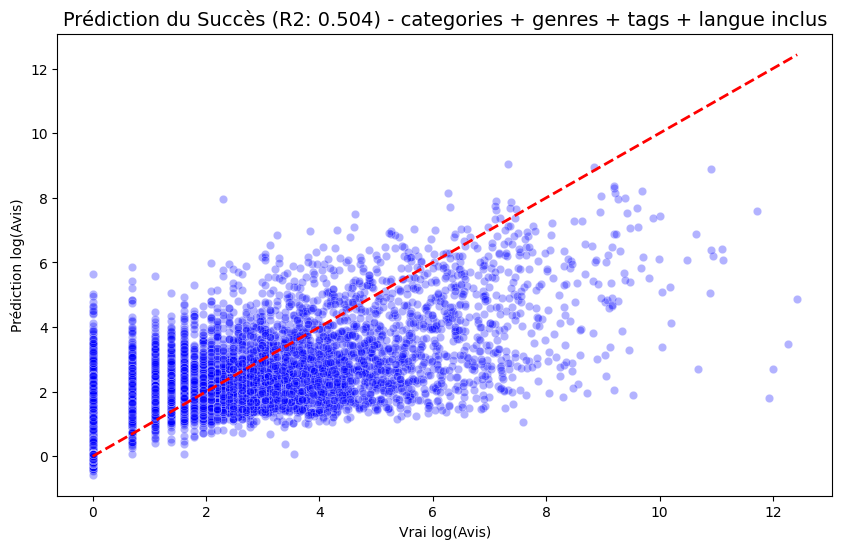

Exemples de prédictions :
                                          Titre  Vrai_Avis  Prediction
1699                                Space Court      145.0    3.570718
43168                              Ecos da Mata        0.0   -0.117381
33423                                 Myristica        3.0    3.949481
11458                            Crimson Spires       61.0   35.359024
41297                          House Number 666        3.0    6.287047
13426     Unsolved Mystery Club: Amelia Earhart       12.0    5.976260
6689                                   Clawsome        0.0   -0.183682
31078                            QuiVr Vanguard        9.0    9.366157
33176  Super Novel Collector (Speedrun Edition)        1.0    4.351152
24190                              Cave Of Evil        0.0    0.060633
          Feature Id  Importances
0               prix    42.912186
1    langues_partiel    26.352537
2      nombre_succes    18.803027
3    langues_complet     7.463221
4  N_langues_partiel   

In [28]:
cols_text = ["langues_partiel","langues_complet"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

test tags

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

# 2. Multi-Hot Encoding
mlb = MultiLabelBinarizer(sparse_output=True)

# Transformation
tags_encoded = mlb.fit_transform(df['tags_utilisateurs'])

print(f"Nombre de tags uniques trouvés : {len(mlb.classes_)}")

tags_df = pd.DataFrame(tags_encoded.toarray(), columns=mlb.classes_, index=df.index)
pca_full = PCA()
pca_full.fit(tags_encoded)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.searchsorted(cumulative_variance, 0.95) + 1
n_components_90 = np.searchsorted(cumulative_variance, 0.90) + 1

print("Dimensions nécessaires pour 95% de variance :", n_components_95)
print("Dimensions nécessaires pour 90% de variance :", n_components_90)

pca = PCA(n_components=n_components_90)
tags_reduced = pca.fit_transform(tags_encoded)
df_pca = pd.DataFrame(
    tags_reduced,
    index=df.index,
    columns=[f'PC{i+1}' for i in range(tags_reduced.shape[1])]
)
df_pca

Nombre de tags uniques trouvés : 446
Dimensions nécessaires pour 95% de variance : 237
Dimensions nécessaires pour 90% de variance : 177


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC168,PC169,PC170,PC171,PC172,PC173,PC174,PC175,PC176,PC177
0,-0.312642,0.114451,-0.706298,-0.738606,-0.462244,0.148709,0.467612,0.465301,-0.287754,0.023539,...,-0.003723,-0.001079,0.004638,-0.007316,0.002899,-0.014926,-0.020970,0.001702,0.012270,-0.003435
1,0.773207,-0.845417,0.623685,-0.217569,-0.542979,0.419410,0.032185,-0.299094,0.146031,0.048646,...,0.057119,-0.139246,0.153431,0.044761,0.095199,-0.032237,0.057764,-0.187894,0.401185,0.139595
2,0.047936,-0.870139,-0.174175,0.000620,0.009022,0.871102,0.554064,0.187085,0.428441,0.369665,...,0.006191,0.047878,-0.039241,0.020057,0.045805,-0.012420,-0.028155,0.045699,0.004630,-0.021000
3,0.391873,0.850537,0.965200,0.000439,-0.289241,-0.465231,0.552857,0.226163,-0.691849,-0.088790,...,-0.043721,-0.014556,0.022398,0.010324,-0.041592,0.040501,0.078365,-0.056658,-0.044788,-0.004705
4,0.343287,-0.721291,1.042840,-0.099273,-0.155626,-0.632363,-0.088334,0.511585,0.558062,0.705532,...,0.090187,0.012166,0.129116,0.013006,-0.025987,0.032534,-0.084708,-0.090974,0.003383,-0.020110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46038,0.198725,-0.126408,-0.837474,-0.460958,0.286897,0.355951,1.028908,-0.014805,-0.076330,-0.627802,...,0.026651,-0.073246,-0.139939,0.011138,-0.009807,-0.022623,-0.051505,0.114565,0.055149,-0.062690
46039,0.804995,-0.771338,0.957855,0.027342,-0.253551,-0.438789,-0.217969,1.053177,0.084523,0.172992,...,0.036325,-0.016351,0.050315,0.034914,-0.005657,0.048354,0.148403,-0.040254,-0.043974,0.027277
46040,-1.155962,-0.770095,0.785932,0.257591,-0.104579,0.494793,-0.278402,-0.242704,-0.359517,-0.057360,...,-0.011087,-0.229580,0.281900,0.158323,0.091747,-0.000935,0.200327,-0.221833,0.321251,0.042648
46041,0.219311,0.327658,0.711219,-1.216891,-0.172052,0.155961,0.146552,0.279039,-0.001753,-0.017578,...,0.024900,0.004858,-0.018007,0.027011,0.007084,0.050735,0.028567,0.008153,-0.001566,0.024796


In [30]:
X = df[["support_manette","prix","nombre_succes",]].copy()
X = pd.concat([X,df_pca],axis=1)
numeric_cols = ["prix", "nombre_succes"]
Y = np.log1p(df['review'])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [31]:
lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0], cv=5, random_state=42)
lasso.fit(X_train, y_train)

y_pred_lr = lasso.predict(X_test)
y_pred = np.expm1(y_pred_lr)
print("Lasso R2:", r2_score(y_test, y_pred_lr))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"Meilleur alpha trouvé : {lasso.alpha_}")
print("Max réel (Log):", np.log1p(y_test).max())
print("Max prédiction (Log):", y_pred_lr.max())
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lasso.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Lasso R2: -0.004046232929233895
Lasso RMSE: 4764.422906033319
Meilleur alpha trouvé : 0.0001
Max réel (Log): 12.428319795196447
Max prédiction (Log): 8.287090463041375
    Feature      Coef
18     PC16  1.508024
59     PC57  1.061870
12     PC10 -0.763036
61     PC59  0.687117
126   PC124  0.680804
28     PC26  0.679807
11      PC9  0.674777
76     PC74  0.663285
114   PC112  0.635792
149   PC147 -0.630375


In [32]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)
y_pred_rf = rf.predict(X_test)
y_pred = np.expm1(y_pred_rf)
print("Random Forest R2:", r2_score(y_test_log, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: 0.5504379964493419
Random Forest RMSE: 4770.631087134625


In [33]:
mlp = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=2000, random_state=42,activation='relu',solver='adam',early_stopping=True,verbose=True)
mlp.fit(X_train, y_train_log)
y_pred_mlp = mlp.predict(X_test)
y_pred = np.expm1(y_pred_mlp)
print("MLP R2:", r2_score(y_test_log, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 1.87203464
Validation score: 0.289739
Iteration 2, loss = 1.46192186
Validation score: 0.342485
Iteration 3, loss = 1.26852145
Validation score: 0.411130
Iteration 4, loss = 1.11099669
Validation score: 0.447462
Iteration 5, loss = 1.02082498
Validation score: 0.447330
Iteration 6, loss = 0.96188690
Validation score: 0.461406
Iteration 7, loss = 0.90409015
Validation score: 0.463490
Iteration 8, loss = 0.84857211
Validation score: 0.465873
Iteration 9, loss = 0.80667793
Validation score: 0.460507
Iteration 10, loss = 0.76817095
Validation score: 0.457076
Iteration 11, loss = 0.73138232
Validation score: 0.444977
Iteration 12, loss = 0.69479603
Validation score: 0.449319
Iteration 13, loss = 0.66913557
Validation score: 0.439952
Iteration 14, loss = 0.63690107
Validation score: 0.447091
Iteration 15, loss = 0.60738996
Validation score: 0.442025
Iteration 16, loss = 0.58150770
Validation score: 0.437118
Iteration 17, loss = 0.55925738
Validation score: 0.430730
Iterat

In [37]:
X

,prix,nombre_succes,support_manette,tags_utilisateurs
0,99,0,False,"[Simulation, Adventure, Indie]"
1,0,0,False,"[Interactive Fiction, Adventure, Family Friend..."
2,1679,43,False,"[Indie, Casual, VR, Immersive Sim, Atmospheric..."
3,0,0,False,"[Aliens, Action, Precision Platformer, Platfor..."
4,79,0,False,"[Old School, Retro, Pixel Graphics, Exploratio..."
...,...,...,...,...
46038,1249,0,False,"[Indie, Simulation, Survival, Massively Multip..."
46039,199,0,False,"[Metroidvania, Puzzle Platformer, Puzzle, Plat..."
46040,0,0,False,"[Action-Adventure, Exploration, Sci-fi, Specta..."
46041,999,59,False,"[Adventure, RPG, Indie, Point & Click, Comedy,..."


In [ ]:
cols_text = ["tags_utilisateurs"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 6. Entraînement CatBoost (Le modèle final)
cb = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=7,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=200,
    early_stopping_rounds=100,
    task_type="CPU"
)

cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 7. Affichage des résultats pour ton rapport
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))

# 8. Graphique "Preuve de réussite"
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - Tags inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

CatBoostError: Invalid type for text_feature[non-default value idx=0,feature_idx=3]=['Strategy' 'Casual' 'Indie' 'Puzzle' 'Chess' 'Action' 'FPS'
 'First-Person' 'Difficult' 'Surreal' 'Abstract' 'Replay Value'
 'Family Friendly' 'Atmospheric' 'Arcade' 'Simulation' 'Fantasy'] : text_features must have string type

Test catboost text

In [ ]:
cols_text = ["description_detaillee"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()

Y = np.log1p(df[target])


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


features = cols_cat+cols_text+numeric_cols
target = "review"

X = df[features]
y_log = np.log1p(df[target]) # On garde le log pour l'entraînement

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - Tags inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

# Exemple de lecture pour quelques jeux
results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': np.expm1(y_test).astype(int),
    'Prediction': np.expm1(y_pred_log).astype(int)
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

In [ ]:
cols_text = ["description_courte"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"


X = df[features].copy()

Y = np.log1p(df[target])


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


features = cols_cat+cols_text+numeric_cols
target = "review"

X = df[features]
y_log = np.log1p(df[target]) # On garde le log pour l'entraînement

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - Tags inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

# Exemple de lecture pour quelques jeux
results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': np.expm1(y_test).astype(int),
    'Prediction': np.expm1(y_pred_log).astype(int)
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

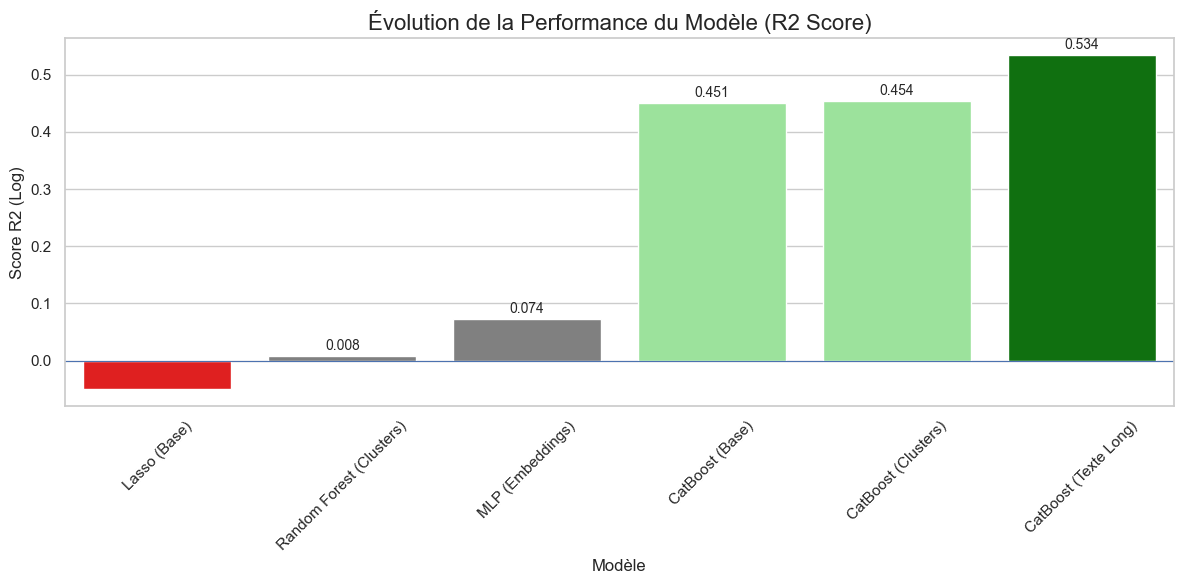

2025-12-16 08:49:53,483 - INFO     - Executing shutdown due to inactivity...
2025-12-16 08:49:53,845 - INFO     - Executing shutdown...
2025-12-16 08:49:53,846 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


In [ ]:
# Tes résultats (approximatifs basés sur nos échanges)
results = pd.DataFrame({
    'Modèle': ['Lasso (Base)', 'Random Forest (Clusters)', 'MLP (Embeddings)','CatBoost (Base)','CatBoost (Clusters)', 'CatBoost (Texte Long)'],
    'R2 Score (Log Space)': [-0.05,0.008, 0.0736,0.451,0.454, 0.534],
    'Type': ['Echec', 'Baseline','Baseline','Baseline', 'Echec','Meilleur']
})

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

colors = [
    'red' if x < 0
    else 'grey' if x < 0.2
    else 'lightgreen' if x < 0.52
    else 'green'
    for x in results['R2 Score (Log Space)']
]

sns.barplot(
    data=results,
    x='Modèle',
    y='R2 Score (Log Space)',
    hue='Modèle',
    palette=colors,
    legend=False
)

plt.title('Évolution de la Performance du Modèle (R2 Score)', fontsize=16)
plt.ylabel('Score R2 (Log)', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(0, linewidth=0.8)

for i, v in enumerate(results['R2 Score (Log Space)']):
    if v > 0:
        plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()

Test genre catégorie catboost

Entraînement sur le texte : ['genres']...
0:	learn: 2.0431051	test: 4770.8270819	best: 4770.8270819 (0)	total: 99.8ms	remaining: 49.8s
100:	learn: 1.4268430	test: 4770.6634076	best: 4770.6634076 (100)	total: 6.63s	remaining: 26.2s
200:	learn: 1.3978330	test: 4770.6518248	best: 4770.6518248 (200)	total: 12.9s	remaining: 19.1s
300:	learn: 1.3661589	test: 4770.6488211	best: 4770.6486046 (287)	total: 19.9s	remaining: 13.2s
400:	learn: 1.3401630	test: 4770.6450635	best: 4770.6449744 (395)	total: 25.6s	remaining: 6.33s
499:	learn: 1.3227171	test: 4770.6441770	best: 4770.6441770 (499)	total: 31.4s	remaining: 0us

bestTest = 4770.644177
bestIteration = 499


🏆 SCORE FINAL (R2 Log) : 0.5344
RMSE: 4736.837277818044

Top Facteurs de Succès :
        Feature Id  Importances
0           genres    41.943657
1             prix    36.227771
2    nombre_succes    21.828572
3  support_manette     0.000000


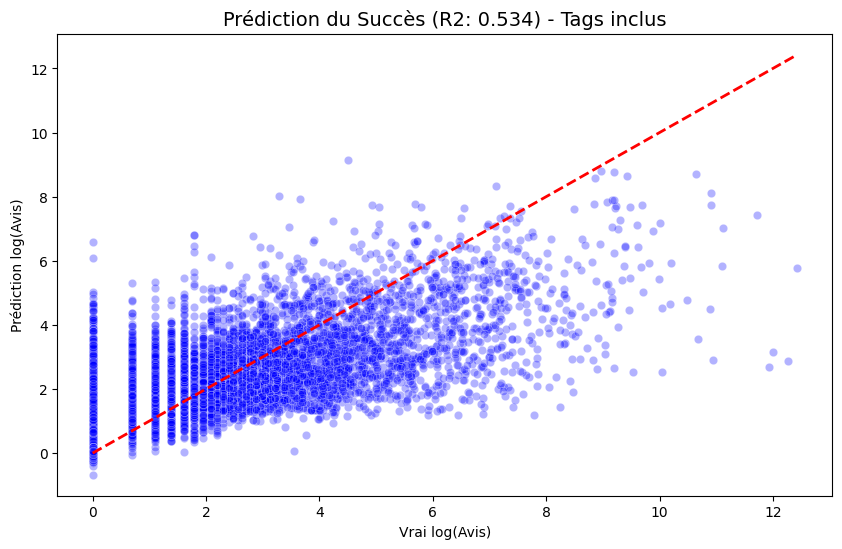

Exemples de prédictions :
                              Titre  Vrai_Avis  Prediction
41694         Eclipse of Eldergaard        0.0   -0.006205
18123       Lovely Memory Challenge        0.0    2.774726
6418   Trivia Vault Football Trivia       15.0  118.781234
44563                     Cyberhunt      442.0   62.219130
38560                  Trade Empire        0.0    0.055626
7217               The Grave Digger       18.0   20.767669
14658                     LoveSoTea        0.0   -0.007159
24983                     KARTMania        1.0    6.322503
17583               To Grant A Wish        3.0   12.117517
14146               Garden Guardian       49.0    7.461904
        Feature Id  Importances
0           genres    41.943657
1             prix    36.227771
2    nombre_succes    21.828572
3  support_manette     0.000000


2025-12-16 19:09:23,380 - INFO     - Executing shutdown due to inactivity...
2025-12-16 19:09:23,482 - INFO     - Executing shutdown...
2025-12-16 19:09:23,483 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


In [ ]:
cols_text = ["genres"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - Tags inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

# Exemple de lecture pour quelques jeux
results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction':y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Entraînement sur le texte : ['categories']...
0:	learn: 2.0343456	test: 4770.8254815	best: 4770.8254815 (0)	total: 219ms	remaining: 1m 49s
100:	learn: 1.2862010	test: 4770.5940515	best: 4770.5940515 (100)	total: 19.4s	remaining: 1m 16s
200:	learn: 1.2502156	test: 4770.5785585	best: 4770.5785585 (200)	total: 37.9s	remaining: 56.4s
300:	learn: 1.2141014	test: 4770.5729128	best: 4770.5729128 (300)	total: 1m 1s	remaining: 40.4s
400:	learn: 1.1904166	test: 4770.5704074	best: 4770.5704074 (400)	total: 1m 20s	remaining: 20s
499:	learn: 1.1734970	test: 4770.5686375	best: 4770.5686375 (499)	total: 1m 39s	remaining: 0us

bestTest = 4770.568638
bestIteration = 499


🏆 SCORE FINAL (R2 Log) : 0.6318
RMSE: 4692.755428223249

Top Facteurs de Succès :
        Feature Id  Importances
0       categories    57.248711
1             prix    32.940410
2    nombre_succes     9.810879
3  support_manette     0.000000


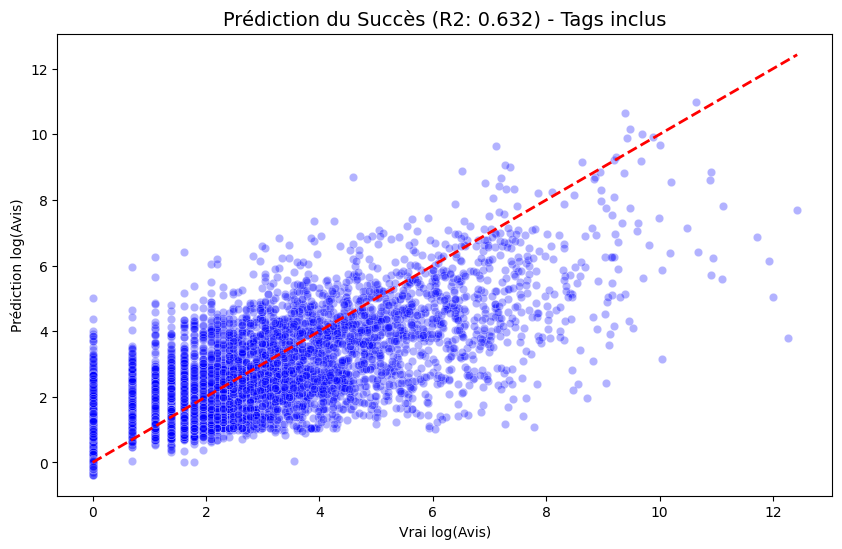

Exemples de prédictions :
                                                   Titre  Vrai_Avis  \
33061                                     Juniper Theory        1.0   
20120                                    Gleaner Heights      236.0   
18370                                           Only Up!       72.0   
20510                          Hunted: Survive the Night        0.0   
39538                                        Cyber Arena        4.0   
35867                               小小无常 Little Wu Chang        1.0   
45412                    Vendetta - Curse of Raven's Cry      137.0   
28125                                           Bit-Boom       19.0   
41338  Wax Museum - Seek and Find - Mystery Hidden Ob...       14.0   
2754                            Thirty Flights of Loving     1050.0   

       Prediction  
33061    2.869973  
20120  340.196807  
18370   10.738346  
20510   -0.081084  
39538    1.600331  
35867   25.274018  
45412  983.706709  
28125    4.621659  
41338    3.1

In [ ]:
cols_text = ["categories"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,          # Raisonnable pour commencer
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"           # Mets "GPU" si tu peux, ça ira 10x plus vite
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - catégories inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

# Exemple de lecture pour quelques jeux
results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Test genre + categorie

Entraînement sur le texte : ['categories', 'genres']...
0:	learn: 2.0344530	test: 4770.8238261	best: 4770.8238261 (0)	total: 444ms	remaining: 3m 41s
100:	learn: 1.2615163	test: 4770.5929002	best: 4770.5929002 (100)	total: 26.3s	remaining: 1m 43s
200:	learn: 1.2182683	test: 4770.5746481	best: 4770.5746481 (200)	total: 55.3s	remaining: 1m 22s
300:	learn: 1.1776516	test: 4770.5674701	best: 4770.5674701 (300)	total: 1m 26s	remaining: 57.1s
400:	learn: 1.1477596	test: 4770.5643868	best: 4770.5642237 (395)	total: 1m 54s	remaining: 28.4s
499:	learn: 1.1248538	test: 4770.5618343	best: 4770.5618292 (497)	total: 2m 24s	remaining: 0us

bestTest = 4770.561829
bestIteration = 497

Shrink model to first 498 iterations.

🏆 SCORE FINAL (R2 Log) : 0.6491
RMSE: 4667.967996498969

Top Facteurs de Succès :
        Feature Id  Importances
0       categories    46.503065
1             prix    29.784937
2           genres    13.520258
3    nombre_succes    10.191740
4  support_manette     0.000000


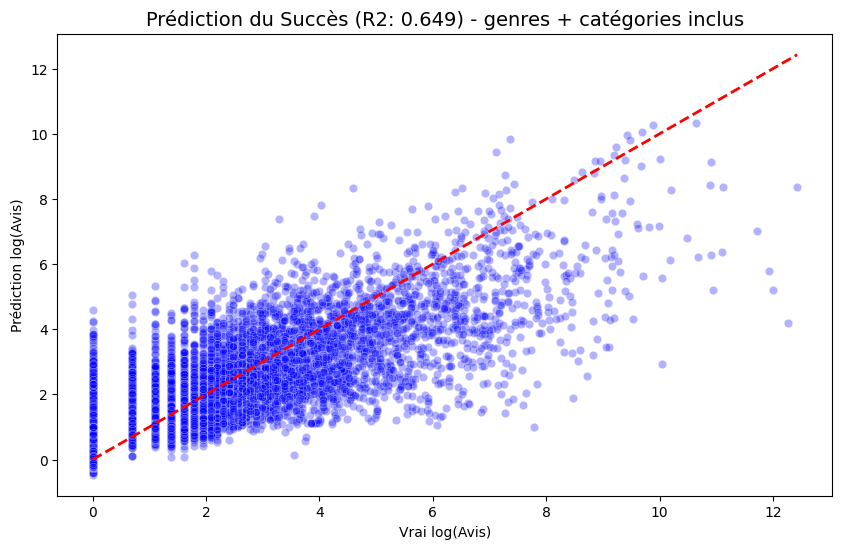

Exemples de prédictions :
                                     Titre  Vrai_Avis  Prediction
22021                         Overflo Game        0.0   -0.060046
34357                  Wreck Poly Survival        0.0    3.781763
11451                        Gravity Panda        0.0    6.500931
16898                 Nico and the Shadows        0.0   -0.152597
18869                        Blood Hunting        7.0    1.171797
13252             The Trolley Problem Game       37.0    3.636137
13857                    PLAY DOG PLAY TAG        1.0    8.346584
35986                            Iris.Fall      336.0  269.503913
1638                                Choice        6.0   19.984757
42222  VELVETIST: The City of Machine Guns        0.0    0.100526
        Feature Id  Importances
0       categories    46.503065
1             prix    29.784937
2           genres    13.520258
3    nombre_succes    10.191740
4  support_manette     0.000000


In [ ]:
cols_text = ["categories","genres"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,          # Raisonnable pour commencer
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"           # Mets "GPU" si tu peux, ça ira 10x plus vite
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - genres + catégories inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

# Exemple de lecture pour quelques jeux
results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Test genre + categorie + tags

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs']...
0:	learn: 2.0349441	test: 4770.8250640	best: 4770.8250640 (0)	total: 816ms	remaining: 13m 34s
100:	learn: 1.1820010	test: 4770.5670805	best: 4770.5670805 (100)	total: 1m 38s	remaining: 14m 33s
200:	learn: 1.1167754	test: 4770.5404250	best: 4770.5404250 (200)	total: 3m 10s	remaining: 12m 36s
300:	learn: 1.0590071	test: 4770.5301618	best: 4770.5301334 (298)	total: 4m 45s	remaining: 11m 1s
400:	learn: 1.0168910	test: 4770.5231952	best: 4770.5231616 (399)	total: 6m 15s	remaining: 9m 20s
500:	learn: 0.9833676	test: 4770.5184923	best: 4770.5183349 (498)	total: 7m 57s	remaining: 7m 56s
600:	learn: 0.9564701	test: 4770.5142437	best: 4770.5142430 (589)	total: 9m 32s	remaining: 6m 19s
700:	learn: 0.9317176	test: 4770.5123694	best: 4770.5123694 (700)	total: 10m 56s	remaining: 4m 40s
800:	learn: 0.9086985	test: 4770.5105777	best: 4770.5104927 (797)	total: 12m 20s	remaining: 3m 4s
900:	learn: 0.8881652	test: 4770.5078122	b

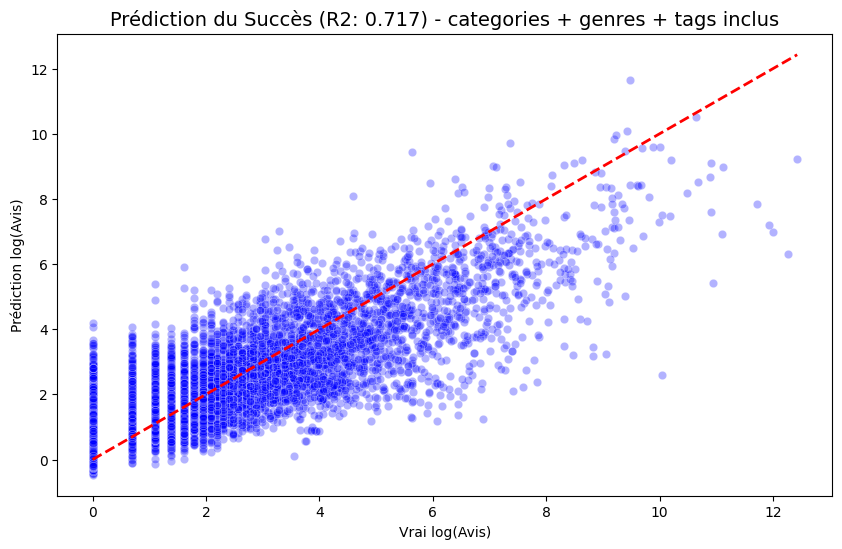

Exemples de prédictions :
                                  Titre  Vrai_Avis  Prediction
3578                    TwoKinds Online        0.0    0.460605
18849                           Alveole       20.0   10.530258
26593                   Death Infection        0.0    0.201724
9293               Slime Dungeon Escape        2.0    1.321827
3886                  Count Dookie Fart       13.0   26.091367
45656                 Library Simulator        0.0   -0.048258
4448   Call of Ponchy : Mahjong Warfare        0.0   -0.058001
32381                     Tic-Toc-Tower       16.0   83.517096
5541                      LVN Fake News       10.0    3.065822
21220                       Passin'Time        0.0   -0.202143
          Feature Id  Importances
0  tags_utilisateurs    31.225663
1         categories    30.348839
2               prix    24.586660
3      nombre_succes     8.291371
4             genres     5.547467
5    support_manette     0.000000


In [ ]:
cols_text = ["categories","genres","tags_utilisateurs"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"           # Mets "GPU" si tu peux, ça ira 10x plus vite
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'description_detaillee']...
0:	learn: 2.0339473	test: 4770.8255546	best: 4770.8255546 (0)	total: 2.06s	remaining: 17m 10s
100:	learn: 1.1850701	test: 4770.5668506	best: 4770.5668506 (100)	total: 2m 46s	remaining: 10m 57s
200:	learn: 1.1181739	test: 4770.5432722	best: 4770.5432722 (200)	total: 5m 38s	remaining: 8m 22s
300:	learn: 1.0511319	test: 4770.5326289	best: 4770.5326289 (300)	total: 8m 22s	remaining: 5m 32s
400:	learn: 0.9996648	test: 4770.5269476	best: 4770.5268099 (398)	total: 11m 15s	remaining: 2m 46s
499:	learn: 0.9593563	test: 4770.5220843	best: 4770.5220843 (499)	total: 14m 18s	remaining: 0us

bestTest = 4770.522084
bestIteration = 499


🏆 SCORE FINAL (R2 Log) : 0.7045
RMSE: 4630.366222390234

Top Facteurs de Succès :
              Feature Id  Importances
0             categories    28.611103
1                   prix    26.090315
2      tags_utilisateurs    22.720994
3  description_detaillee    10.902

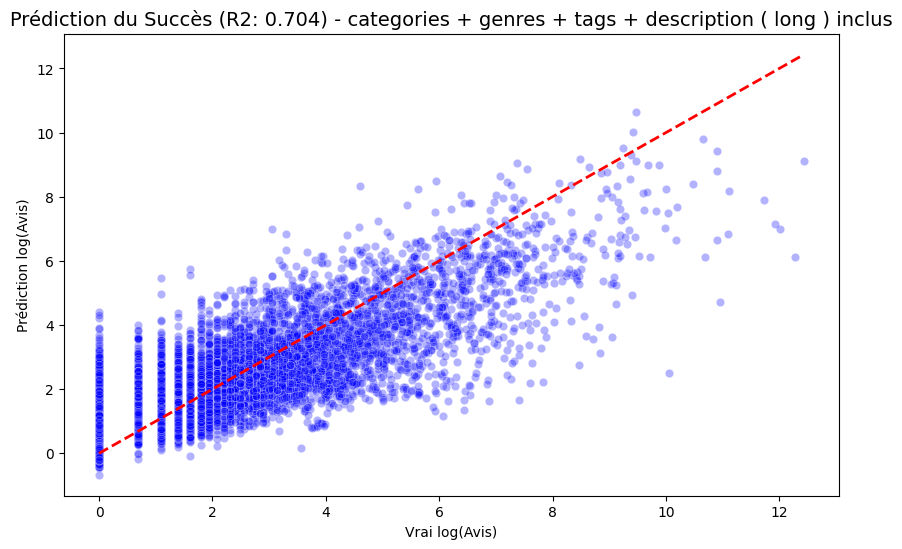

Exemples de prédictions :
                   Titre  Vrai_Avis  Prediction
28250           Unlocked       12.0   11.704663
42285               Juke        1.0    7.472689
43249              FeelV        0.0    3.483892
15612        Elder Chaos       13.0    8.732157
3593              Unheil        0.0    0.075352
14749   Island Beekeeper        0.0    0.515711
32929         Disembowel       18.0   14.308957
44682   Inferno Sentinel        1.0    0.865610
29650     Zombie Waiting        7.0    5.210742
25495  CPA:Reports Bousy        0.0    0.125779
              Feature Id  Importances
0             categories    28.611103
1                   prix    26.090315
2      tags_utilisateurs    22.720994
3  description_detaillee    10.902108
4          nombre_succes     7.730426
5                 genres     3.945054
6        support_manette     0.000000


In [ ]:
cols_text = ["categories","genres","tags_utilisateurs","description_detaillee"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"           # Mets "GPU" si tu peux, ça ira 10x plus vite
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + description ( long ) inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'description_detaillee']...
0:	learn: 2.0320624	test: 4770.8249369	best: 4770.8249369 (0)	total: 331ms	remaining: 2m 44s
100:	learn: 1.1978907	test: 4770.5560550	best: 4770.5560550 (100)	total: 18.4s	remaining: 1m 12s
200:	learn: 1.1396611	test: 4770.5249145	best: 4770.5249145 (200)	total: 35.3s	remaining: 52.5s
300:	learn: 1.1002739	test: 4770.5116750	best: 4770.5116750 (299)	total: 52.1s	remaining: 34.5s
400:	learn: 1.0742646	test: 4770.5064538	best: 4770.5064538 (400)	total: 1m 8s	remaining: 16.9s
499:	learn: 1.0512551	test: 4770.5023514	best: 4770.5023514 (499)	total: 1m 25s	remaining: 0us
bestTest = 4770.502351
bestIteration = 499

🏆 SCORE FINAL (R2 Log) : 0.6972
RMSE: 4661.987952557642

 SCORE TRAIN (R2 Log) : 0.7464
Erreur Médiane : 3.0135964653289102

Top Facteurs de Succès :
              Feature Id  Importances
0             categories    32.798320
1                   prix    26.960278
2      tags_utili

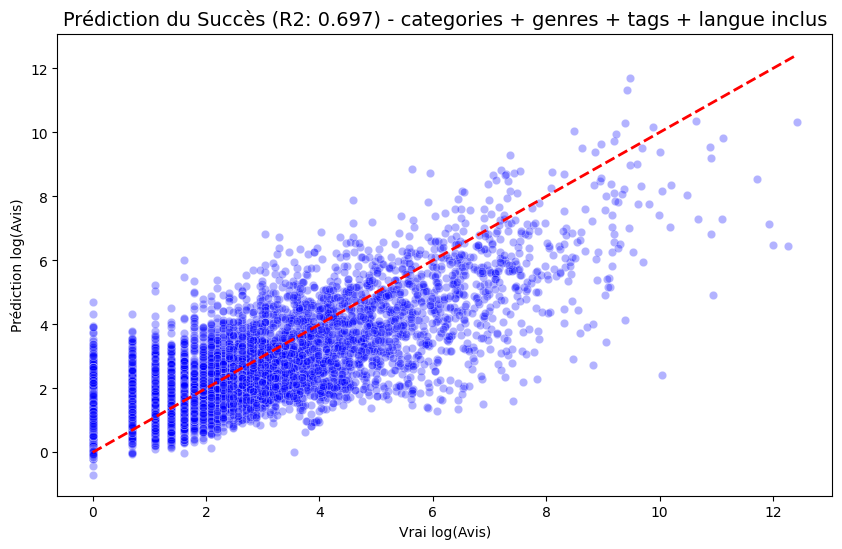

Exemples de prédictions :
                         Titre  Vrai_Avis  Prediction
6029      The Enchanted Worlds        0.0    4.005111
38838            Crash Drive 3       93.0  711.702454
902    Emily Wants to Play Too      184.0   88.220253
33151                  Myasoid       15.0    9.077952
17210                   Tankex       17.0    5.515527
26253    A Knight in the Attic        3.0    4.699980
2245             Just Desserts        3.0    1.576142
21333                  유어 블라이트        2.0  183.663349
30332        Fighting For Food        0.0    1.217192
42082              Fingerdance       14.0    6.777468
              Feature Id  Importances
0             categories    32.798320
1                   prix    26.960278
2      tags_utilisateurs    23.920931
3          nombre_succes     6.773801
4  description_detaillee     5.957253
5                 genres     3.589417
6        support_manette     0.000000


In [ ]:
cols_text = ["categories","genres","tags_utilisateurs","description_detaillee"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="GPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Test genre catégorie tags langue

In [35]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    task_type="GPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'langues_partiel', 'langues_complet']...


CatBoostError: catboost/libs/train_lib/trainer_env.cpp:9: Environment for task type [GPU] not found

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'langues_partiel', 'langues_complet', 'description_detaillee']...
Learning rate set to 0.091678
0:	learn: 1.9889773	test: 4770.8172920	best: 4770.8172920 (0)	total: 172ms	remaining: 2m 52s
100:	learn: 1.1171572	test: 4770.5195068	best: 4770.5195068 (100)	total: 1m 5s	remaining: 9m 44s
200:	learn: 1.0533563	test: 4770.5062673	best: 4770.5062673 (193)	total: 2m 11s	remaining: 8m 41s
300:	learn: 1.0122996	test: 4770.5017920	best: 4770.5017920 (300)	total: 3m 16s	remaining: 7m 35s
400:	learn: 0.9795859	test: 4770.4991814	best: 4770.4991814 (396)	total: 4m 20s	remaining: 6m 29s
500:	learn: 0.9537776	test: 4770.4965708	best: 4770.4963843 (497)	total: 5m 26s	remaining: 5m 25s
600:	learn: 0.9271019	test: 4770.4958249	best: 4770.4947061 (547)	total: 6m 30s	remaining: 4m 19s
700:	learn: 0.9064391	test: 4770.4941467	best: 4770.4939602 (698)	total: 7m 34s	remaining: 3m 13s
800:	learn: 0.8897555	test: 4770.4924684	best: 4770.

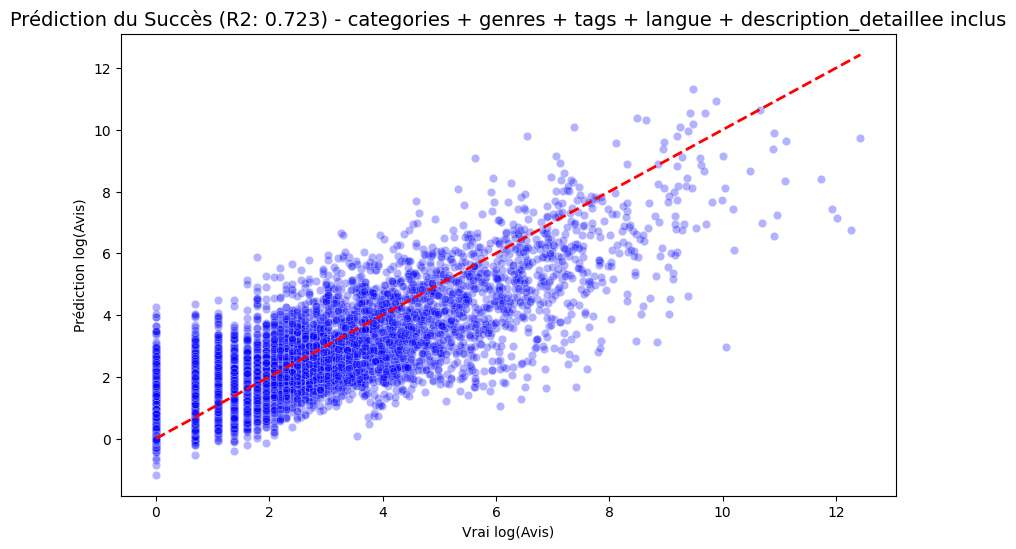

Exemples de prédictions :
                                           Titre  Vrai_Avis  Prediction
45575                            Russell's Range        3.0    3.787505
1188                             茶ノ魔 -Cha-No-Ma-        0.0    0.495153
13130                          Lost in Blindness        7.0   17.091826
30691                               Ninja Tycoon      162.0   63.862681
40650                               Minimal Move        1.0   18.206021
43978                            A Highland Song      348.0   30.092493
21964                                  Crisálida        0.0    0.090905
7778   CyberRebeat -The Fifth Domain of Warfare-        6.0  135.851386
7762                             Margin of Error        0.0   -0.064806
22373                   Battle Investment Master        0.0    0.947805
               Feature Id  Importances
0              categories    27.033240
1                    prix    23.753135
2       tags_utilisateurs    22.499100
3   description_detaillee 

In [ ]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet","description_detaillee"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    depth=12,
    text_features=cols_text,
    verbose=100,
    task_type="GPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue + description_detaillee inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)